In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde  # For better time feature distribution matching
from torch.utils.tensorboard import SummaryWriter  # TensorBoard for loss tracking

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class CRBM(nn.Module):
    def __init__(self, n_visible, n_hidden, n_conditions):
        super(CRBM, self).__init__()
        
        # Xavier initialization for stability
        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * np.sqrt(2.0/(n_visible + n_hidden)))
        self.b = nn.Parameter(torch.zeros(n_visible))
        self.a = nn.Parameter(torch.zeros(n_hidden))
        self.U = nn.Parameter(torch.randn(n_conditions, n_hidden) * np.sqrt(2.0/(n_conditions + n_hidden)))
        
        self.batch_norm = nn.BatchNorm1d(n_hidden)  # Adding batch normalization

        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_conditions = n_conditions
    
    def free_energy(self, v, c):
        """Compute the free energy with KL regularization"""
        vW = torch.matmul(v, self.W)
        cU = torch.matmul(c, self.U)
        hidden_activations = self.batch_norm(self.a + vW + cU)  # Apply batch norm
        hidden_term = F.softplus(hidden_activations).sum(dim=1)

        # KL divergence term to prevent mode collapse
        kl_term = 0.01 * torch.sum(self.W ** 2)
        
        return -torch.matmul(v, self.b) - hidden_term + kl_term
    
    def sample_h_given_v_c(self, v, c, temperature=1.0):
        """Sample hidden units with temperature scaling"""
        v, c = v.to(device), c.to(device)
        activation = (torch.matmul(v, self.W) + torch.matmul(c, self.U) + self.a) / temperature
        p_h = torch.sigmoid(activation)
        return p_h, torch.bernoulli(p_h)
    
    def sample_v_given_h(self, h):
        """Sample visible units given hidden units with clamping"""
        h = h.to(device)
        activation = torch.matmul(h, self.W.t()) + self.b
        p_v = torch.sigmoid(torch.clamp(activation, -80, 80))
        return p_v, torch.bernoulli(p_v)
    
    def gibbs_sampling(self, v, c, k=50):  # Increased k from 10 to 50
        """Perform k-step Gibbs sampling"""
        v, c = v.to(device), c.to(device)
        v_k = v
        for _ in range(k):
            p_h, h = self.sample_h_given_v_c(v_k, c)
            p_v, v_k = self.sample_v_given_h(h)
        return p_v, v_k, p_h, h
    
    def contrastive_divergence(self, v_pos, c, k=1):
        """Contrastive Divergence with k steps"""
        v_pos, c = v_pos.to(device), c.to(device)
        p_h_pos, h_pos = self.sample_h_given_v_c(v_pos, c)
        p_v_neg, v_neg, p_h_neg, h_neg = self.gibbs_sampling(v_pos, c, k)
        return p_h_pos, h_pos, p_v_neg, v_neg, p_h_neg, h_neg
    
    def forward(self, v, c):
        """Forward pass"""
        p_h, h = self.sample_h_given_v_c(v, c)
        return p_h, h

In [4]:
def load_credit_card_data(file_path):
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        print("Trying alternative path...")
        # Try alternative paths
        alternative_paths = ['creditcard.csv', '../creditcard.csv', './data/creditcard.csv']
        for path in alternative_paths:
            try:
                data = pd.read_csv(path)
                print(f"Successfully loaded from {path}")
                break
            except FileNotFoundError:
                continue
        else:
            raise FileNotFoundError(f"Could not find creditcard.csv in any of the expected locations")
    
    # Separate features and target
    X = data.drop('Class', axis=1)
    y = data['Class']
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # One-hot encode the target
    encoder = OneHotEncoder(sparse_output=False)
    y_onehot = encoder.fit_transform(y.values.reshape(-1, 1))
    
    return X_scaled, y, y_onehot, scaler, encoder

In [5]:
def train_crbm(model, X_train, y_onehot_train, batch_size=64, num_epochs=20, lr=0.01, k=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure model is on the correct device
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Learning rate decay
    
    # ✅ Move dataset to device before creating TensorDataset
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_onehot_train_tensor = torch.FloatTensor(y_onehot_train).to(device)

    dataset = TensorDataset(X_train_tensor, y_onehot_train_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, 
                            persistent_workers=True if batch_size > 1 else False)

    writer = SummaryWriter()  # TensorBoard logger
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (v, c) in enumerate(dataloader):
            v, c = v.to(device), c.to(device)  # ✅ Move batch to device
            
            # ✅ Ensure all operations happen on the same device
            p_h_pos, h_pos, p_v_neg, v_neg, p_h_neg, h_neg = model.contrastive_divergence(v, c, k)
            loss = torch.mean(model.free_energy(v, c) - model.free_energy(v_neg, c))
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Gradient clipping
            optimizer.step()
            
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(dataloader)
        losses.append(avg_epoch_loss)
        writer.add_scalar("CRBM/Loss", avg_epoch_loss, epoch)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}')
        scheduler.step()

    writer.close()
    return losses

In [6]:
def generate_synthetic_samples(model, condition_vector, n_samples=100, gibbs_steps=50):
    v = torch.rand(n_samples, model.n_visible)
    c = condition_vector.repeat(n_samples, 1)
    
    for _ in range(gibbs_steps):
        p_h, h = model.sample_h_given_v_c(v, c, temperature=0.8)  # Use temperature scaling
        p_v, v = model.sample_v_given_h(h)
    
    return v.cpu().detach().numpy() 

In [7]:
def generate_realistic_time_distribution(original_df, synthetic_df):
    """Match time distribution using KDE"""
    fraud_times = original_df[original_df['Class'] == 1]['Time'].values
    kde = gaussian_kde(fraud_times)
    synthetic_times = kde.resample(len(synthetic_df)).flatten()
    
    synthetic_df['Time'] = np.clip(synthetic_times, original_df['Time'].min(), original_df['Time'].max())
    return synthetic_df

In [8]:
def visualize_results(original_df, balanced_df, feature_columns, n_samples=1000):
    """
    Visualize the results of the synthetic data generation
    
    Parameters:
    - original_df: DataFrame with original imbalanced data
    - balanced_df: DataFrame with balanced data (original + synthetic)
    - feature_columns: List of feature column names
    - n_samples: Number of samples to use for visualization (for performance)
    """
    
    plt.figure(figsize=(15, 12))
    
    # 1. Class Distribution Before and After
    plt.subplot(2, 2, 1)
    original_counts = original_df['Class'].value_counts()
    balanced_counts = balanced_df['Class'].value_counts()
    
    pd.DataFrame({
        'Original': original_counts,
        'Balanced': balanced_counts
    }).plot(kind='bar', ax=plt.gca())
    plt.title('Class Distribution Before and After Balancing')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'], rotation=0)
    
    # 2. Feature Distributions Comparison (for top 5 features)
    top_features = feature_columns[:5]  # Just show first 5 features for clarity
    
    plt.subplot(2, 2, 2)
    for feature in top_features:
        sns.kdeplot(original_df[original_df['Class']==0][feature], label='Original Non-Fraud')
        sns.kdeplot(original_df[original_df['Class']==1][feature], label='Original Fraud')
        sns.kdeplot(balanced_df[balanced_df['Class']==1][feature], 
                    label='Synthetic Fraud', linestyle='--')
    plt.title('Feature Distributions Comparison')
    plt.xlabel('Feature Values (Standardized)')
    plt.ylabel('Density')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 3. t-SNE Visualization (on subsample for performance)
    plt.subplot(2, 2, 3)
    
    # Subsample the data for visualization
    sample_orig = original_df.sample(min(n_samples, len(original_df)), random_state=42)
    sample_bal = balanced_df[balanced_df['Class']==1].sample(
        min(n_samples, sum(balanced_df['Class']==1)), random_state=42)
    
    # Combine samples
    viz_data = pd.concat([
        sample_orig[feature_columns],
        sample_bal[feature_columns]
    ])
    
    labels = np.concatenate([
        sample_orig['Class'].values,
        np.ones(len(sample_bal))  # All synthetic are fraud
    ])
    
    # Reduce dimensionality with PCA first for better performance
    pca = PCA(n_components=10)
    pca_data = pca.fit_transform(viz_data)
    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(pca_data)
    
    # Plot
    for class_label, color in zip([0, 1], ['blue', 'red']):
        mask = labels == class_label
        plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1], 
                    c=color, label=f'Class {class_label}', alpha=0.6)
    
    # Highlight synthetic points
    synthetic_mask = np.concatenate([
        np.zeros(len(sample_orig)),
        np.ones(len(sample_bal))
    ]).astype(bool)
    
    plt.scatter(tsne_results[synthetic_mask, 0], tsne_results[synthetic_mask, 1],
                c='green', label='Synthetic Fraud', marker='x', alpha=0.8)
    
    plt.title('t-SNE Visualization of Original and Synthetic Data')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    
    # 4. Correlation Matrix Difference
    plt.subplot(2, 2, 4)
    orig_corr = original_df[feature_columns].corr()
    bal_corr = balanced_df[feature_columns].corr()
    corr_diff = bal_corr - orig_corr
    
    sns.heatmap(corr_diff, cmap='coolwarm', center=0, 
                annot=False, fmt=".2f", 
                cbar_kws={'label': 'Correlation Difference'})
    plt.title('Difference in Feature Correlations\n(Balanced - Original)')
    
    plt.tight_layout()
    plt.show()

Epoch 1/50, Loss: 2.8537
Epoch 2/50, Loss: -3.3861
Epoch 3/50, Loss: -6.2468
Epoch 4/50, Loss: -7.3309
Epoch 5/50, Loss: -7.7219
Epoch 6/50, Loss: -7.6869
Epoch 7/50, Loss: -7.4229
Epoch 8/50, Loss: -7.0183
Epoch 9/50, Loss: -6.5630
Epoch 10/50, Loss: -6.0950
Epoch 11/50, Loss: -5.7504
Epoch 12/50, Loss: -5.5059
Epoch 13/50, Loss: -5.2648
Epoch 14/50, Loss: -5.0458
Epoch 15/50, Loss: -4.8206
Epoch 16/50, Loss: -4.6539
Epoch 17/50, Loss: -4.5530
Epoch 18/50, Loss: -4.4518
Epoch 19/50, Loss: -4.3491
Epoch 20/50, Loss: -4.2408
Epoch 21/50, Loss: -4.1602
Epoch 22/50, Loss: -4.1133
Epoch 23/50, Loss: -4.0740
Epoch 24/50, Loss: -4.0163
Epoch 25/50, Loss: -3.9712
Epoch 26/50, Loss: -3.9279
Epoch 27/50, Loss: -3.9073
Epoch 28/50, Loss: -3.8817
Epoch 29/50, Loss: -3.8693
Epoch 30/50, Loss: -3.8363
Epoch 31/50, Loss: -3.8311
Epoch 32/50, Loss: -3.8143
Epoch 33/50, Loss: -3.7891
Epoch 34/50, Loss: -3.7840
Epoch 35/50, Loss: -3.7679
Epoch 36/50, Loss: -3.7625
Epoch 37/50, Loss: -3.7597
Epoch 38/50

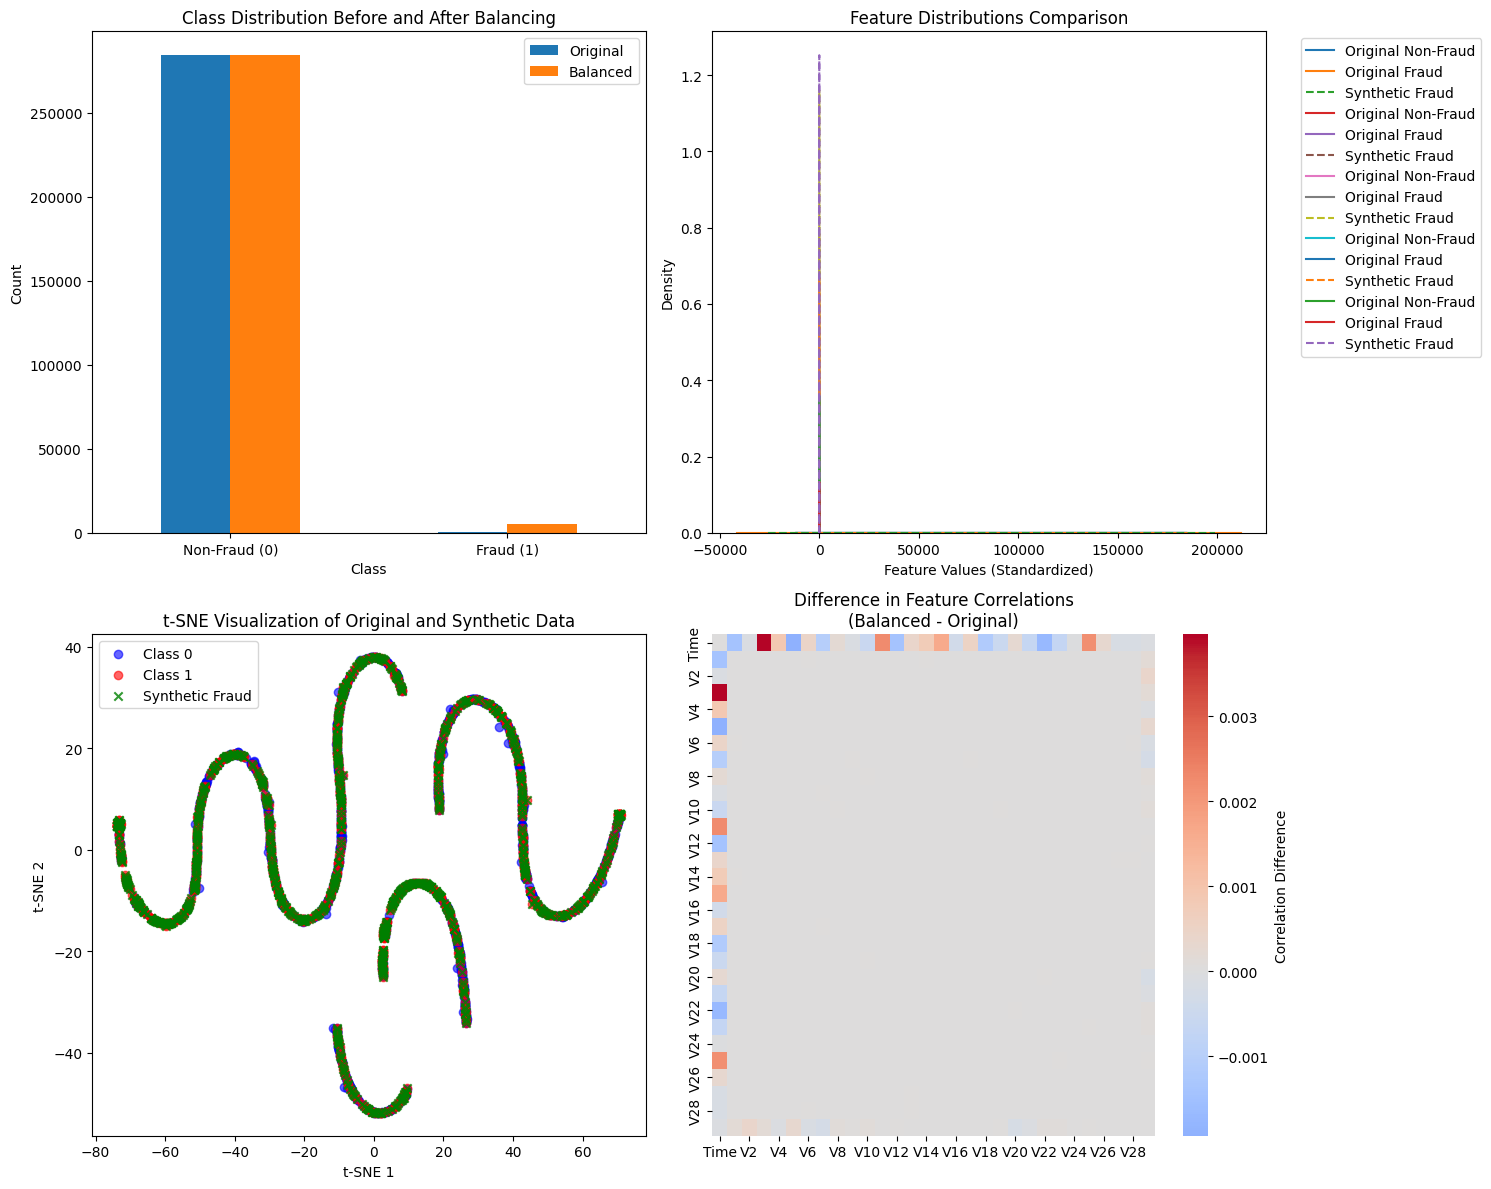

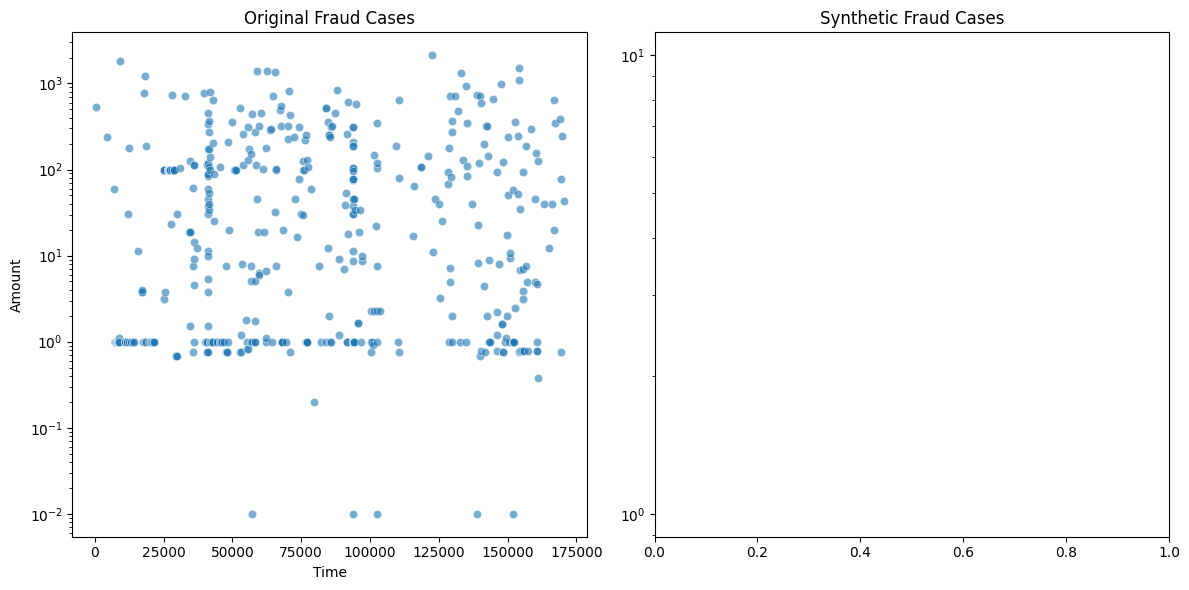

In [9]:
def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    data = pd.read_csv('data/creditcard.csv')
    feature_columns = data.drop('Class', axis=1).columns.tolist()
    
    X = data.drop('Class', axis=1).values
    y = data['Class'].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    encoder = OneHotEncoder(sparse_output=False)
    y_onehot = encoder.fit_transform(y.reshape(-1, 1))
    
    X_train, _, y_train, _, y_onehot_train, _ = train_test_split(X_scaled, y, y_onehot, test_size=0.2, stratify=y)
    
    crbm = CRBM(X_train.shape[1], 64, y_onehot_train.shape[1])
    train_crbm(crbm, X_train, y_onehot_train, num_epochs=50, lr=0.0001, k=1)
    
    fraud_condition = torch.FloatTensor(encoder.transform([[1]]))
    synthetic_fraud_samples = generate_synthetic_samples(crbm, fraud_condition, n_samples=5000, gibbs_steps=50)
    
    synthetic_df = pd.DataFrame(scaler.inverse_transform(synthetic_fraud_samples), columns=feature_columns)
    synthetic_df['Class'] = 1
    synthetic_df = generate_realistic_time_distribution(data, synthetic_df)
    
    balanced_df = pd.concat([data, synthetic_df], ignore_index=True)
    balanced_df.to_csv('balanced_creditcard.csv', index=False)
    print("Balanced dataset saved.")

    print("\nGenerating visualizations...")
    
    # Load original data again for comparison
    original_data = pd.read_csv('data/creditcard.csv')
    feature_columns = original_data.drop('Class', axis=1).columns.tolist()
    
    # Generate visualizations
    visualize_results(original_data, balanced_df, feature_columns)
    
    # Additional visualization: Time vs Amount for fraud cases
    plt.figure(figsize=(12, 6))
    
    # Original fraud
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=original_data[original_data['Class']==1],
                    x='Time', y='Amount', alpha=0.6)
    plt.title('Original Fraud Cases')
    plt.yscale('log')  # Many small amounts
    
    # Synthetic fraud
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=balanced_df[balanced_df['Class']==1].iloc[len(original_data):],
                    x='Time', y='Amount', color='red', alpha=0.6)
    plt.title('Synthetic Fraud Cases')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()